In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import os

In [2]:
parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)

/Users/dtjgp/Projects/GreenAI/PVWatts


In [3]:
# 1. 加载数据
data = pd.read_csv(os.path.join(parent_dir,'Data/alexnet/CombinedInfo/EpochEnergy_f.csv'))
data

,40,45,50,55,60,65,70,75,80,85,90,95
0,2683.07,2371.09,2341.95,2405.66,2509.99,2582.94,2696.77,2812.54,2935.01,3090.42,3167.15,3273.83
1,2700.27,2396.25,2328.66,2449.11,2554.19,2636.43,2691.77,2882.49,3000.85,3167.97,3221.32,3282.47
2,2738.96,2398.51,2376.83,2449.64,2557.75,2638.04,2762.67,2880.62,2991.36,3140.99,3263.48,3415.52
3,2740.38,2398.44,2376.24,2448.69,2555.82,2636.39,2763.72,2880.53,2989.76,3143.88,3262.43,3426.08
4,2738.02,2397.76,2378.69,2449.12,2554.21,2637.55,2762.96,2881.49,2967.87,3141.93,3226.04,3416.91
5,2738.10,2392.36,2428.08,2449.27,2556.63,2638.20,2761.69,2884.82,2967.85,3143.12,3229.22,3390.18
6,2739.46,2396.52,2376.97,2451.98,2557.79,2637.47,2758.40,2885.30,2978.69,3141.56,3231.35,3387.15
7,2738.68,2401.07,2378.54,2450.20,2556.00,2636.76,2760.67,2885.48,2966.37,3144.54,3232.65,3387.42
8,2738.32,2399.18,2378.71,2450.84,2556.99,2637.35,2761.38,2881.09,2973.04,3147.55,3230.88,3390.66
9,2739.35,2396.86,2377.64,2449.79,2557.82,2638.07,2761.43,2882.64,2964.09,3142.43,3230.87,3388.50


In [4]:
# 2. 准备数据集：按列划分输入（X）和目标（Y）
# X 表示不同的功耗设定
X = data.columns[:].astype(float).values.reshape(-1, 1)  # 以每列的列名值作为输入特征
Y = data.iloc[:, :].values.T  # 每列的数据按行作为输出（目标值）
print(X)
print(Y)

[[40.]
 [45.]
 [50.]
 [55.]
 [60.]
 [65.]
 [70.]
 [75.]
 [80.]
 [85.]
 [90.]
 [95.]]
[[2683.07 2700.27 2738.96 2740.38 2738.02 2738.1  2739.46 2738.68 2738.32
  2739.35]
 [2371.09 2396.25 2398.51 2398.44 2397.76 2392.36 2396.52 2401.07 2399.18
  2396.86]
 [2341.95 2328.66 2376.83 2376.24 2378.69 2428.08 2376.97 2378.54 2378.71
  2377.64]
 [2405.66 2449.11 2449.64 2448.69 2449.12 2449.27 2451.98 2450.2  2450.84
  2449.79]
 [2509.99 2554.19 2557.75 2555.82 2554.21 2556.63 2557.79 2556.   2556.99
  2557.82]
 [2582.94 2636.43 2638.04 2636.39 2637.55 2638.2  2637.47 2636.76 2637.35
  2638.07]
 [2696.77 2691.77 2762.67 2763.72 2762.96 2761.69 2758.4  2760.67 2761.38
  2761.43]
 [2812.54 2882.49 2880.62 2880.53 2881.49 2884.82 2885.3  2885.48 2881.09
  2882.64]
 [2935.01 3000.85 2991.36 2989.76 2967.87 2967.85 2978.69 2966.37 2973.04
  2964.09]
 [3090.42 3167.97 3140.99 3143.88 3141.93 3143.12 3141.56 3144.54 3147.55
  3142.43]
 [3167.15 3221.32 3263.48 3262.43 3226.04 3229.22 3231.35 3232.65

In [5]:
# 3. 将数据转换为长格式，每个 (GPU功耗, 能耗) 成对数据
# 展开X和Y以形成新的DataFrame
X_expanded = np.repeat(X, Y.shape[1], axis=0)  # 重复每个最大功耗多次
Y_expanded = Y.flatten()  # 将能耗矩阵展平为1维
print(X_expanded.shape)

(120, 1)


In [6]:
# 4. 创建长格式的 DataFrame
expanded_data = pd.DataFrame({'Max Power': X_expanded.flatten(), 'Energy Consumption': Y_expanded})
expanded_data

,Max Power,Energy Consumption
0,40.0,2683.07
1,40.0,2700.27
2,40.0,2738.96
3,40.0,2740.38
4,40.0,2738.02
...,...,...
115,95.0,3390.18
116,95.0,3387.15
117,95.0,3387.42
118,95.0,3390.66


In [7]:
# 5. 分离特征和目标
X_long = expanded_data[['Max Power']].values
Y_long = expanded_data['Energy Consumption'].values
print(X_long.T)
print(Y_long)

[[40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 45. 45. 45. 45. 45. 45. 45. 45.
  45. 45. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 55. 55. 55. 55. 55. 55.
  55. 55. 55. 55. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 65. 65. 65. 65.
  65. 65. 65. 65. 65. 65. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 75. 75.
  75. 75. 75. 75. 75. 75. 75. 75. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
  85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 90. 90. 90. 90. 90. 90. 90. 90.
  90. 90. 95. 95. 95. 95. 95. 95. 95. 95. 95. 95.]]
[2683.07 2700.27 2738.96 2740.38 2738.02 2738.1  2739.46 2738.68 2738.32
 2739.35 2371.09 2396.25 2398.51 2398.44 2397.76 2392.36 2396.52 2401.07
 2399.18 2396.86 2341.95 2328.66 2376.83 2376.24 2378.69 2428.08 2376.97
 2378.54 2378.71 2377.64 2405.66 2449.11 2449.64 2448.69 2449.12 2449.27
 2451.98 2450.2  2450.84 2449.79 2509.99 2554.19 2557.75 2555.82 2554.21
 2556.63 2557.79 2556.   2556.99 2557.82 2582.94 2636.43 2638.04 2636.39
 2637.55 2638.2  2637.47 2636.76 2637.35 2638.07 2696.77 2691.77 2

#### using the poly lr model to predict the test data

Training MSE: 1450.9197, R2: 0.9857
Testing MSE: 1241.9307, R2: 0.9889


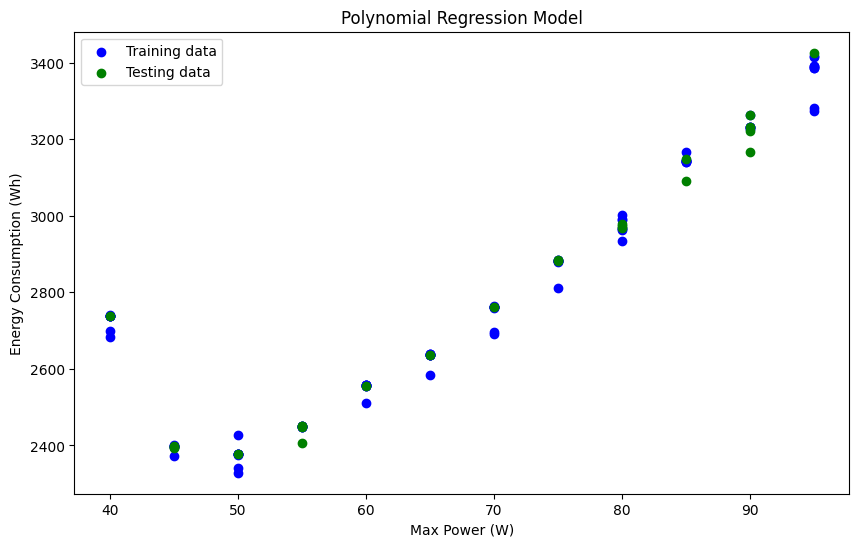

In [8]:
# 创建一个包含多项式特征的线性回归模型
degree = 4  # 设置多项式的最高阶数
poly_lr_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
    ('linear_regression', LinearRegression())
])

# shuffle the data
np.random.seed(42)
shuffle_index = np.random.permutation(len(X_long))
X_long, Y_long = X_long[shuffle_index], Y_long[shuffle_index]

# 拆分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_long, Y_long, test_size=0.2, random_state=42)

# 训练模型
poly_lr_model.fit(X_train, y_train)

# 预测
y_pred_train = poly_lr_model.predict(X_train)
y_pred = poly_lr_model.predict(X_test)

# 计算模型的性能
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred)

print(f"Training MSE: {train_mse:.4f}, R2: {train_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R2: {test_r2:.4f}")

# 绘制模型的预测结果
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Testing data')
# plt.plot(X_train, y_pred_train, color='red', label='Fitted model')
plt.xlabel('Max Power (W)')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Polynomial Regression Model')
plt.legend()
plt.show()

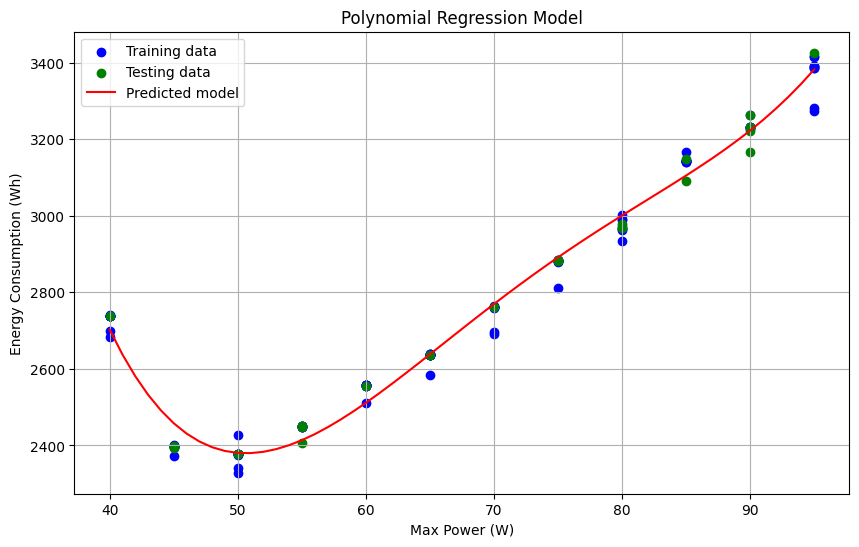

In [9]:
# using the model to predict the energy consumption of a GPU from 40 to 95 W
EnergyConsump_predict = []
for i in range(40, 96):
    EnergyConsump_predict.append(poly_lr_model.predict([[i]]))

# 绘制预测结果
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Testing data')
plt.plot(range(40, 96), EnergyConsump_predict, color='red', label='Predicted model')
plt.xlabel('Max Power (W)')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Polynomial Regression Model')
plt.legend()
plt.grid()
plt.show()

In [10]:
# save the model
import joblib
model_filename = 'EnergyConsump_predict_model.joblib'
joblib.dump(poly_lr_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to EnergyConsump_predict_model.joblib


#### using GBR algorithm to solve the problem

5-Fold Cross-Validated MSE: 701.7941049325976
5-Fold Cross-Validated MAE: 16.6760570962551


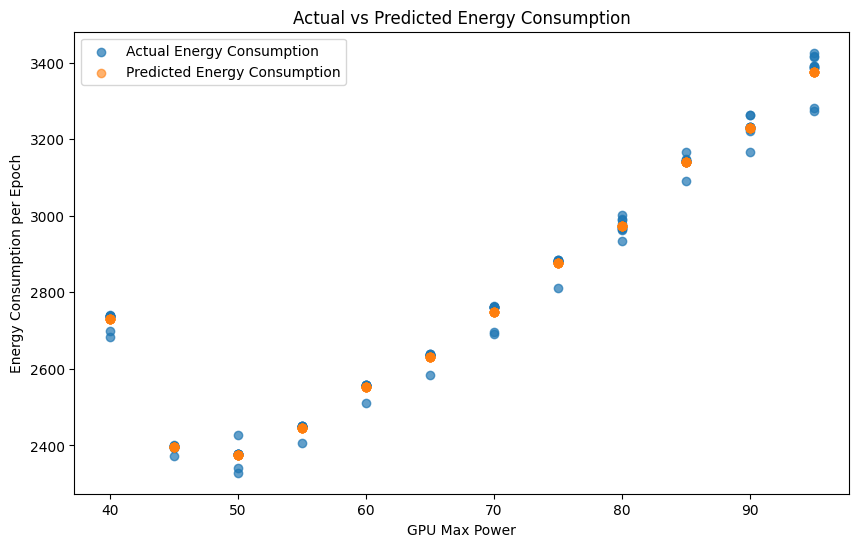

Predicted Energy Consumption for Max Power 35: 2729.455781187549
Predicted Energy Consumption for Max Power 68: 2748.144212625829
Predicted Energy Consumption for Max Power 68: 3229.5250286450946


In [11]:
# 6. 使用梯度提升回归模型
gbr_model = GradientBoostingRegressor(random_state=42)

# 7. 进行5折交叉验证，评估模型性能
mse_scores_long = cross_val_score(gbr_model, X_long, Y_long, scoring='neg_mean_squared_error', cv=5)
mae_scores_long = cross_val_score(gbr_model, X_long, Y_long, scoring='neg_mean_absolute_error', cv=5)

# 转换为正值，并计算平均误差
mean_mse_long = -np.mean(mse_scores_long)
mean_mae_long = -np.mean(mae_scores_long)

print(f"5-Fold Cross-Validated MSE: {mean_mse_long}")
print(f"5-Fold Cross-Validated MAE: {mean_mae_long}")

# 8. 在整个数据集上训练模型
gbr_model.fit(X_long, Y_long)

# 9. 绘制实际值与预测值的对比图
Y_pred_long = gbr_model.predict(X_long)
plt.figure(figsize=(10, 6))
plt.scatter(X_long, Y_long, label='Actual Energy Consumption', alpha=0.7)
plt.scatter(X_long, Y_pred_long, label='Predicted Energy Consumption', alpha=0.6)
plt.xlabel('GPU Max Power')
plt.ylabel('Energy Consumption per Epoch')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()

# 10. 预测新的功率上限值（例如 35 或 68）
power_input_35 = np.array([[35]])
predicted_energy_consumption_35 = gbr_model.predict(power_input_35)
print(f"Predicted Energy Consumption for Max Power 35: {predicted_energy_consumption_35[0]}")

power_input_68 = np.array([[68]])
predicted_energy_consumption_68 = gbr_model.predict(power_input_68)
print(f"Predicted Energy Consumption for Max Power 68: {predicted_energy_consumption_68[0]}")

power_input_68 = np.array([[88]])
predicted_energy_consumption_68 = gbr_model.predict(power_input_68)
print(f"Predicted Energy Consumption for Max Power 68: {predicted_energy_consumption_68[0]}")